In [1]:
# 1. Import Libraries

# Genel veri işleme
import pandas as pd
import numpy as np

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Modelleme ve değerlendirme
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score
)

# Veri ön işleme
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_transformer

# Özellik seçimi
from sklearn.feature_selection import SelectKBest, f_classif

# Makine öğrenmesi modelleri
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Diğer
from scipy.stats import norm
import pickle


In [2]:
import pandas as pd

data = pd.read_csv("bank-additional.csv", sep=';')
print(data.shape)
print(data.head())


(4119, 21)
   age          job  marital          education default  housing     loan  \
0   30  blue-collar  married           basic.9y      no      yes       no   
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0   cellular   may         fri  ...         2    999         0  nonexistent   
1  telephone   may         fri  ...         4    999         0  nonexistent   
2  telephone   jun         wed  ...         1    999         0  nonexistent   
3  telephone   jun         fri  ...         3    999         0  nonexistent   
4   cellular   nov         mon  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euri

In [3]:
# 3. Show basic statistical summary of numerical columns
summary = data.describe()
print("Statistical summary of numerical features:")
print(summary)

Statistical summary of numerical features:
               age     duration     campaign        pdays     previous  \
count  4119.000000  4119.000000  4119.000000  4119.000000  4119.000000   
mean     40.113620   256.788055     2.537266   960.422190     0.190337   
std      10.313362   254.703736     2.568159   191.922786     0.541788   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   103.000000     1.000000   999.000000     0.000000   
50%      38.000000   181.000000     2.000000   999.000000     0.000000   
75%      47.000000   317.000000     3.000000   999.000000     0.000000   
max      88.000000  3643.000000    35.000000   999.000000     6.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx    euribor3m  nr.employed  
count   4119.000000     4119.000000    4119.000000  4119.000000  4119.000000  
mean       0.084972       93.579704     -40.499102     3.621356  5166.481695  
std        1.563114        0.579349       4.594578   

In [4]:
# 4. Show dataset information
print("Dataset structure and data types:")
data.info()


Dataset structure and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17 

In [5]:
# 5. Data Cleaning
print("Initial shape of the dataset:", data.shape)

# Check for duplicates
num_duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Drop duplicates if any
if num_duplicates > 0:
    data.drop_duplicates(inplace=True)
    print(f"Shape after dropping duplicates: {data.shape}")

# Replace 'unknown' values with NaN for proper missing value handling
data.replace('unknown', np.nan, inplace=True)

# Fill missing values column-wise using each column's mode
for col in data.columns:
    data[col] = data[col].fillna(data[col].mode()[0])

print("Missing values have been handled.")


Initial shape of the dataset: (4119, 21)
Number of duplicate rows: 0
Missing values have been handled.


In [6]:
# 6. Identify categorical columns
categorical_cols = data.select_dtypes(include='object').columns.tolist()

print(f"Categorical columns ({len(categorical_cols)} total):")
print(categorical_cols)

Categorical columns (11 total):
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [7]:
# 7. Identify numerical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Numerical columns ({len(numerical_cols)} total):")
print(numerical_cols)

Numerical columns (10 total):
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [8]:
# 8. Display value counts for each categorical column
for col in categorical_cols:
    print(f"\nValue counts for '{col}':")
    print(data[col].value_counts(dropna=False))  # includes NaN if any
    print('-' * 90)


Value counts for 'job':
job
admin.           1051
blue-collar       884
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
Name: count, dtype: int64
------------------------------------------------------------------------------------------

Value counts for 'marital':
marital
married     2520
single      1153
divorced     446
Name: count, dtype: int64
------------------------------------------------------------------------------------------

Value counts for 'education':
education
university.degree      1431
high.school             921
basic.9y                574
professional.course     535
basic.4y                429
basic.6y                228
illiterate                1
Name: count, dtype: int64
------------------------------------------------------------------------------------------

Value counts for 'default':
default
no     4118
yes 

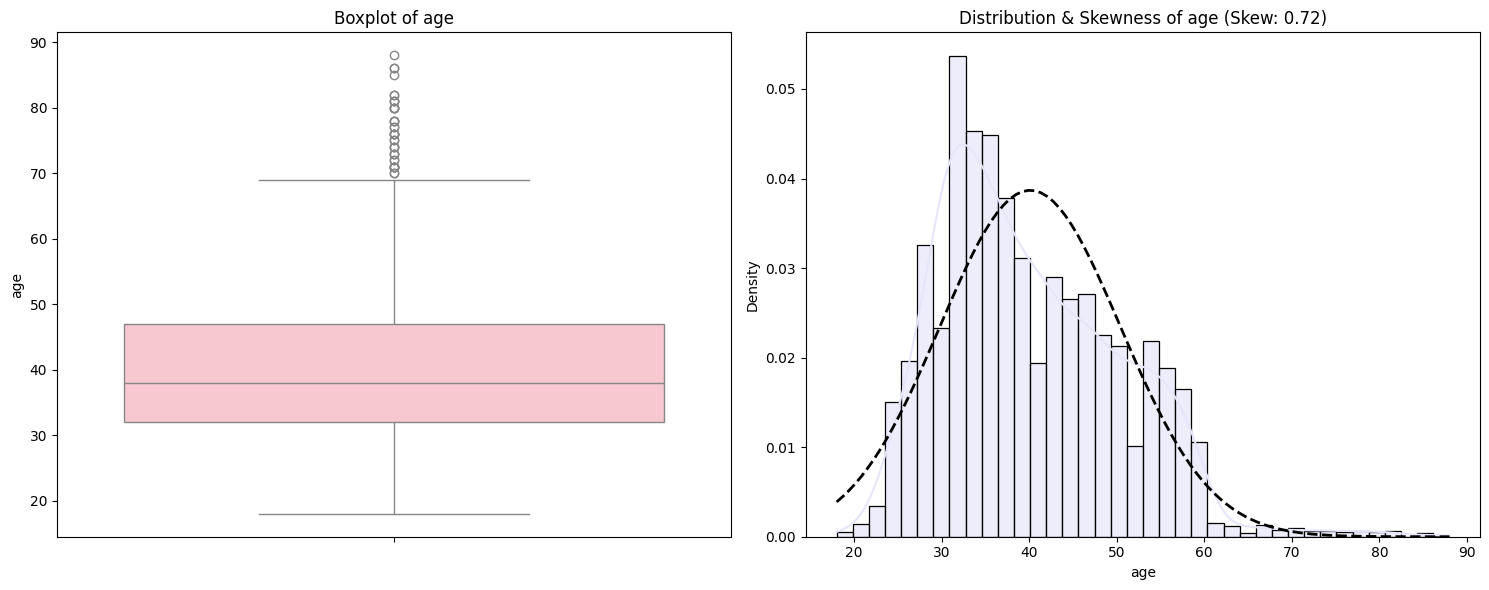

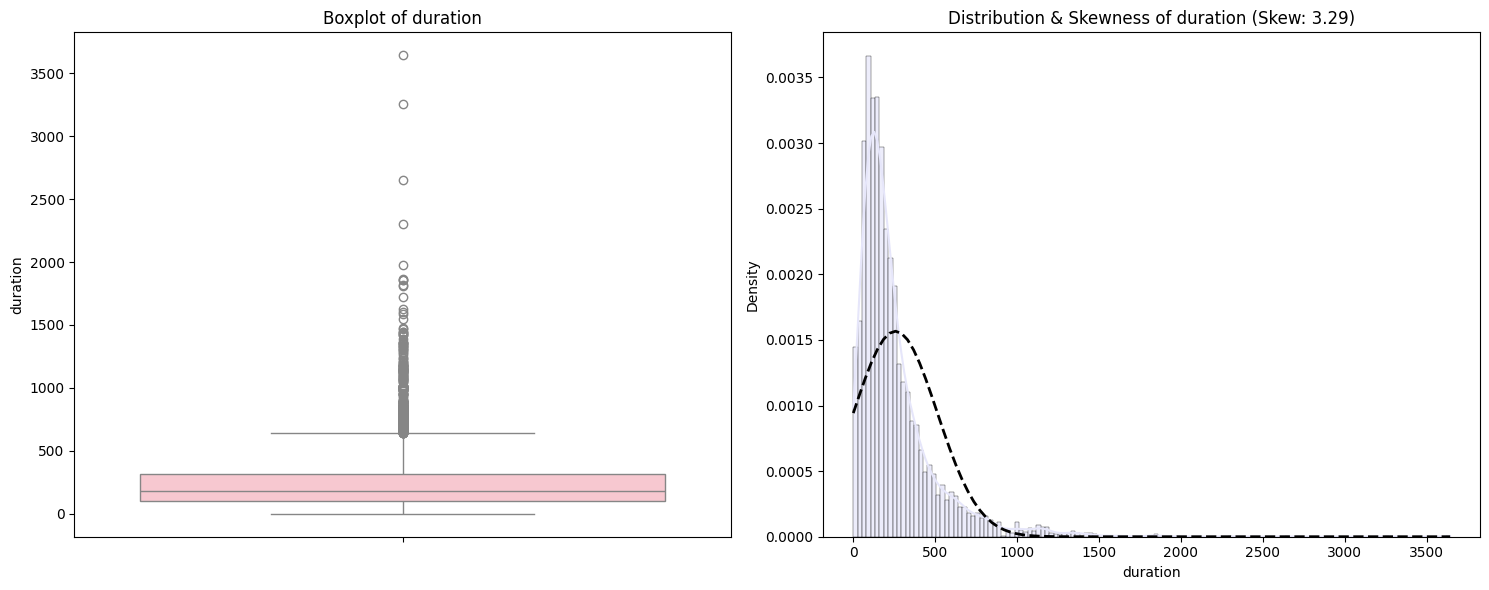

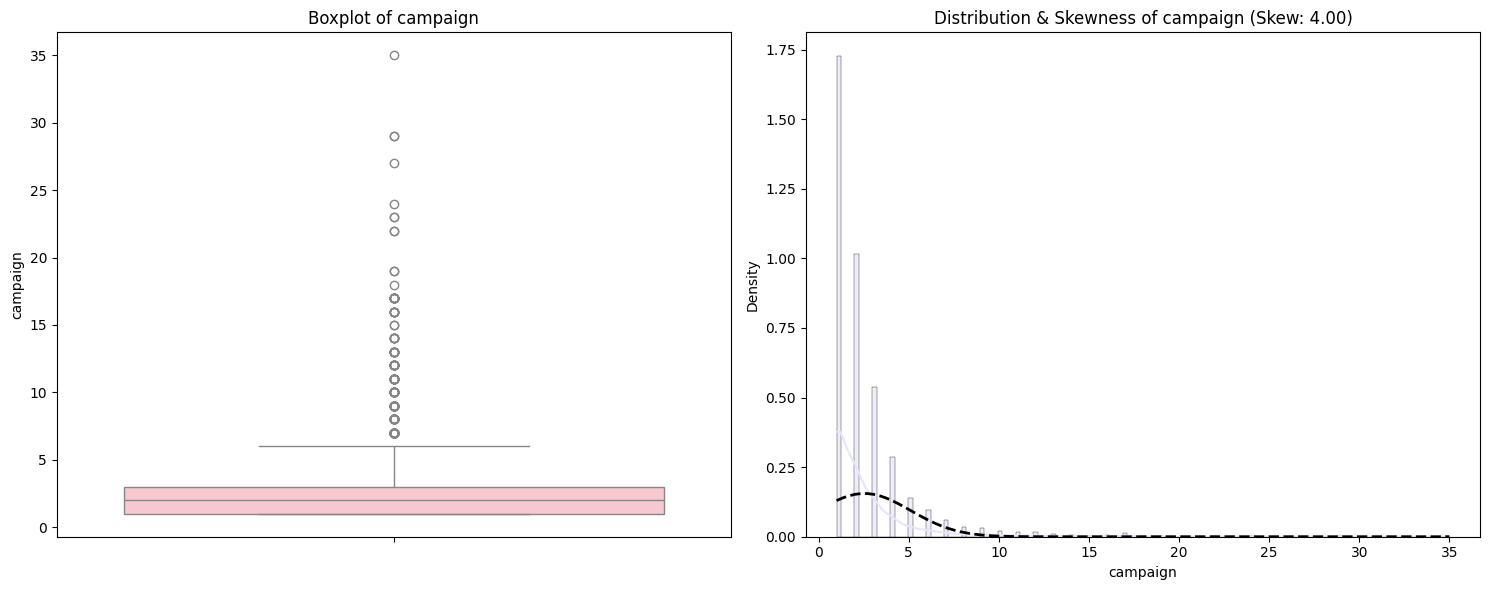

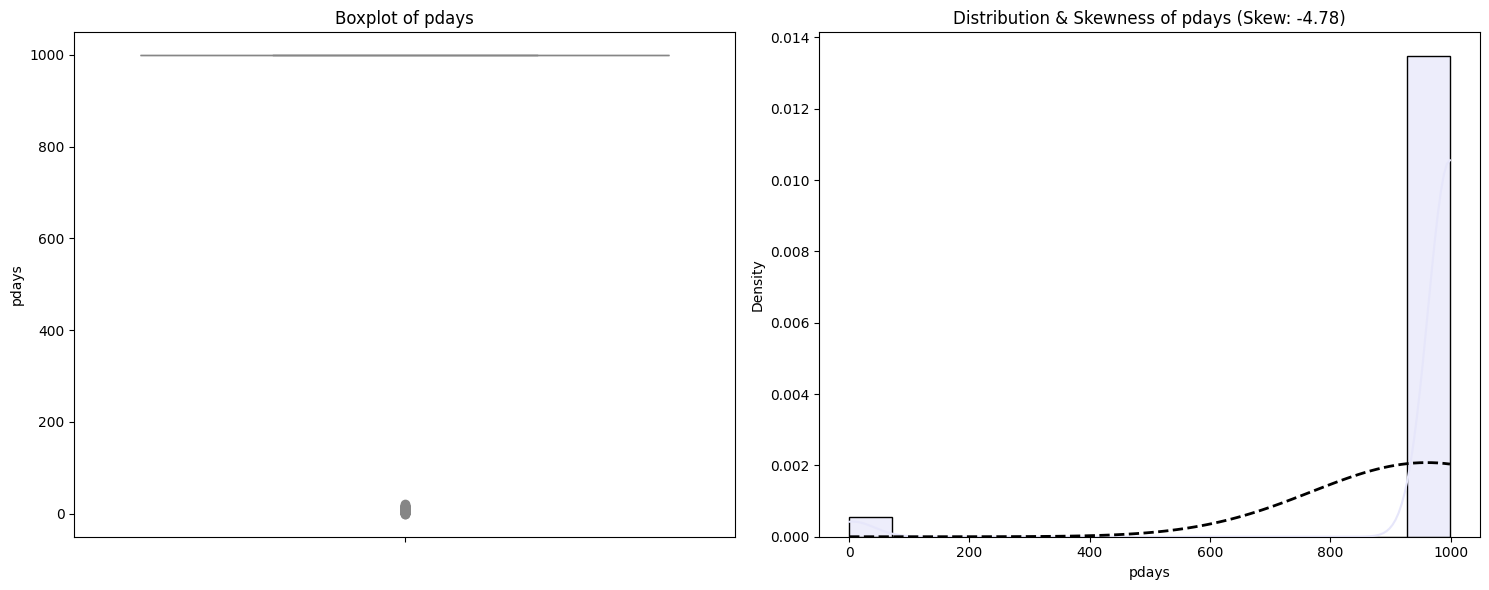

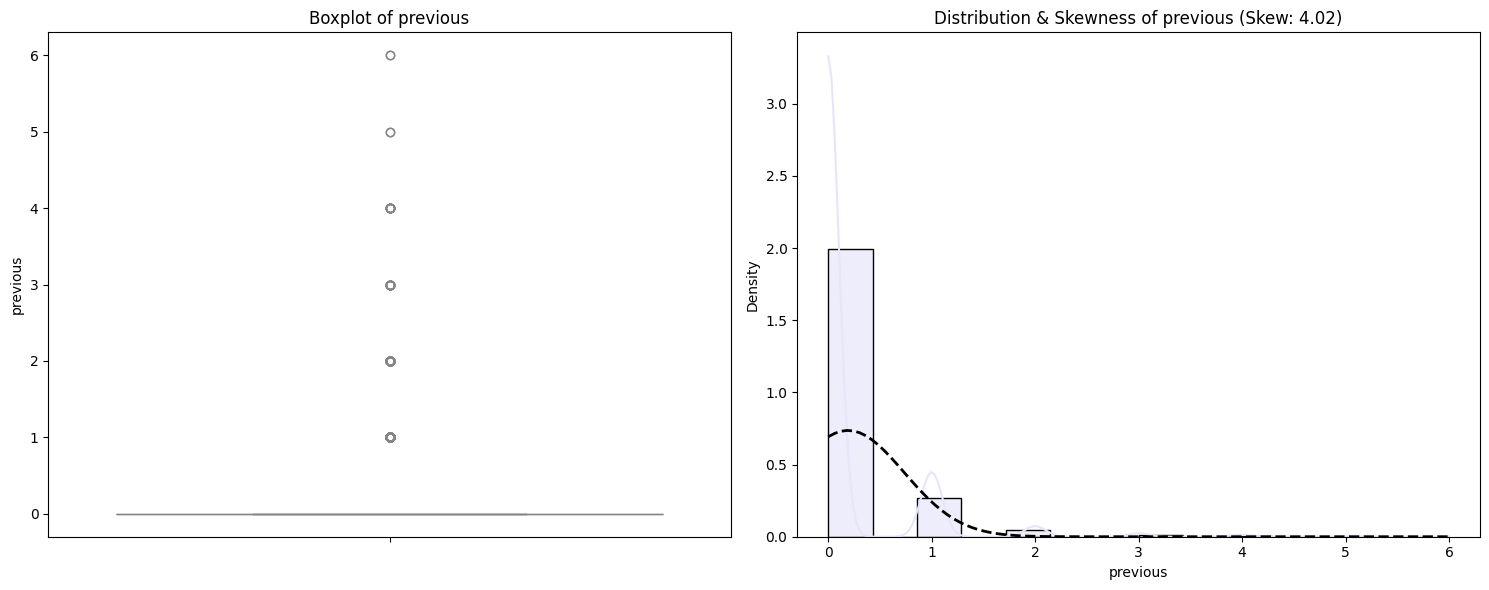

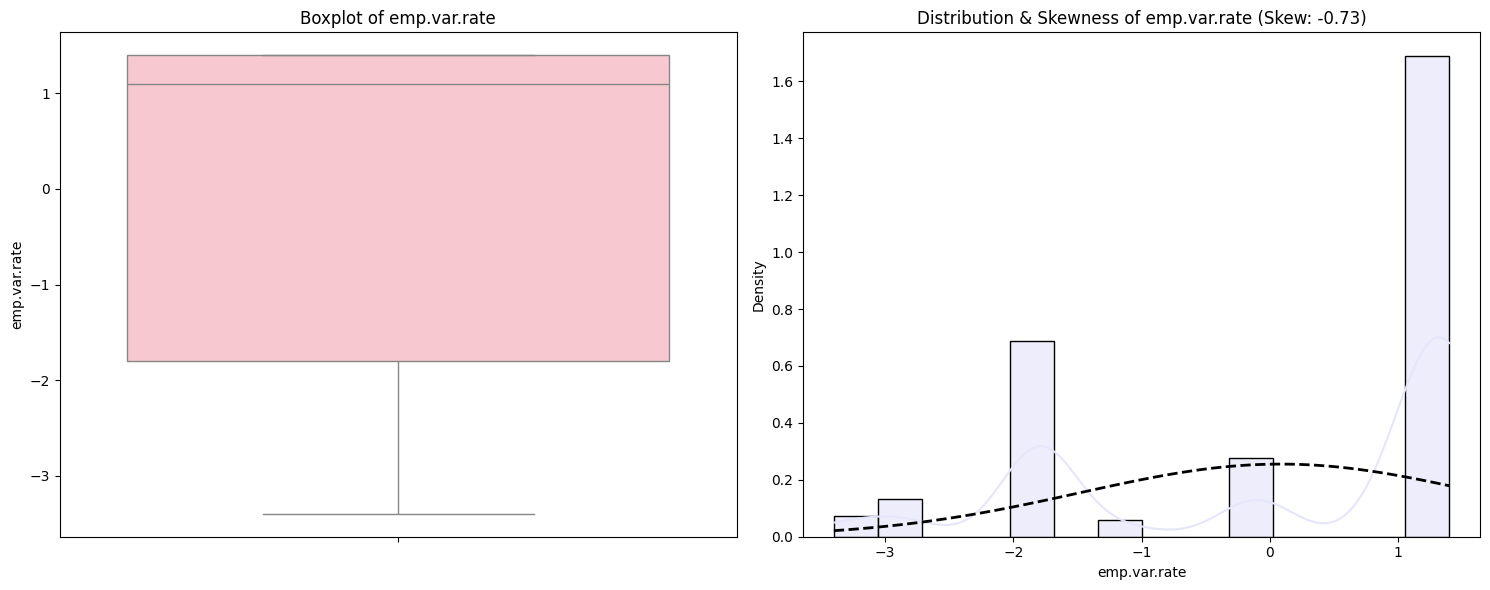

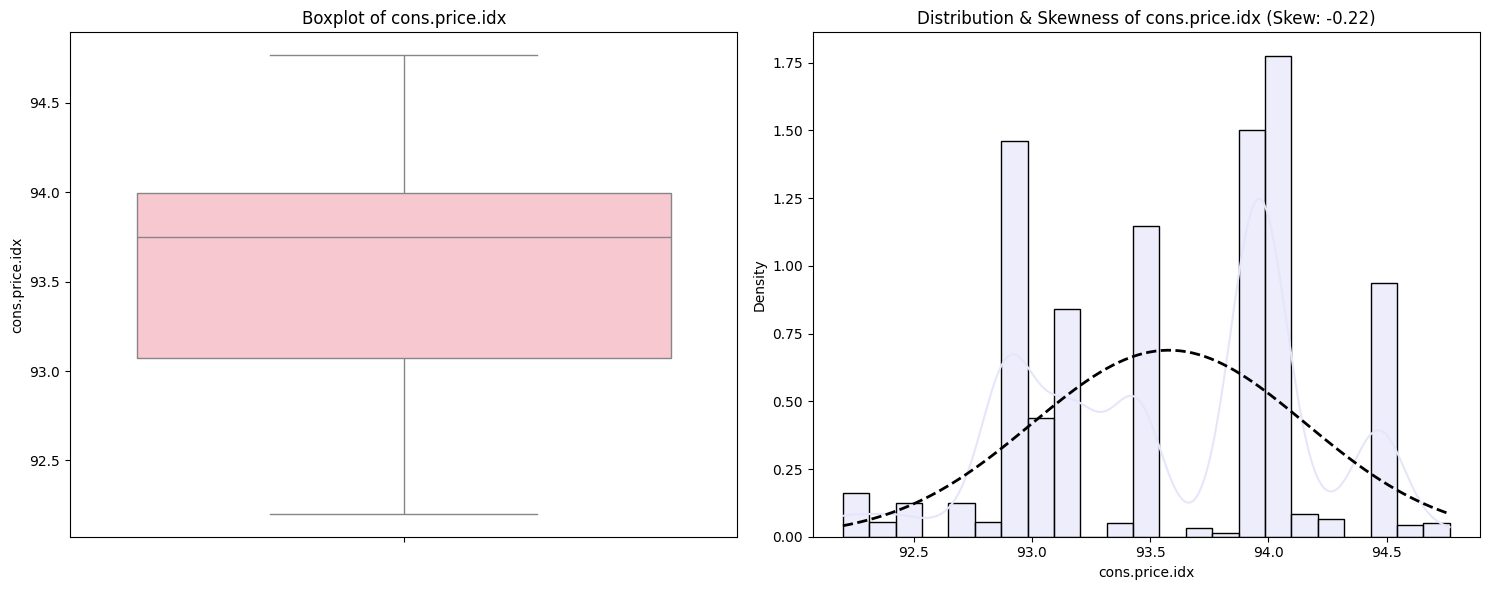

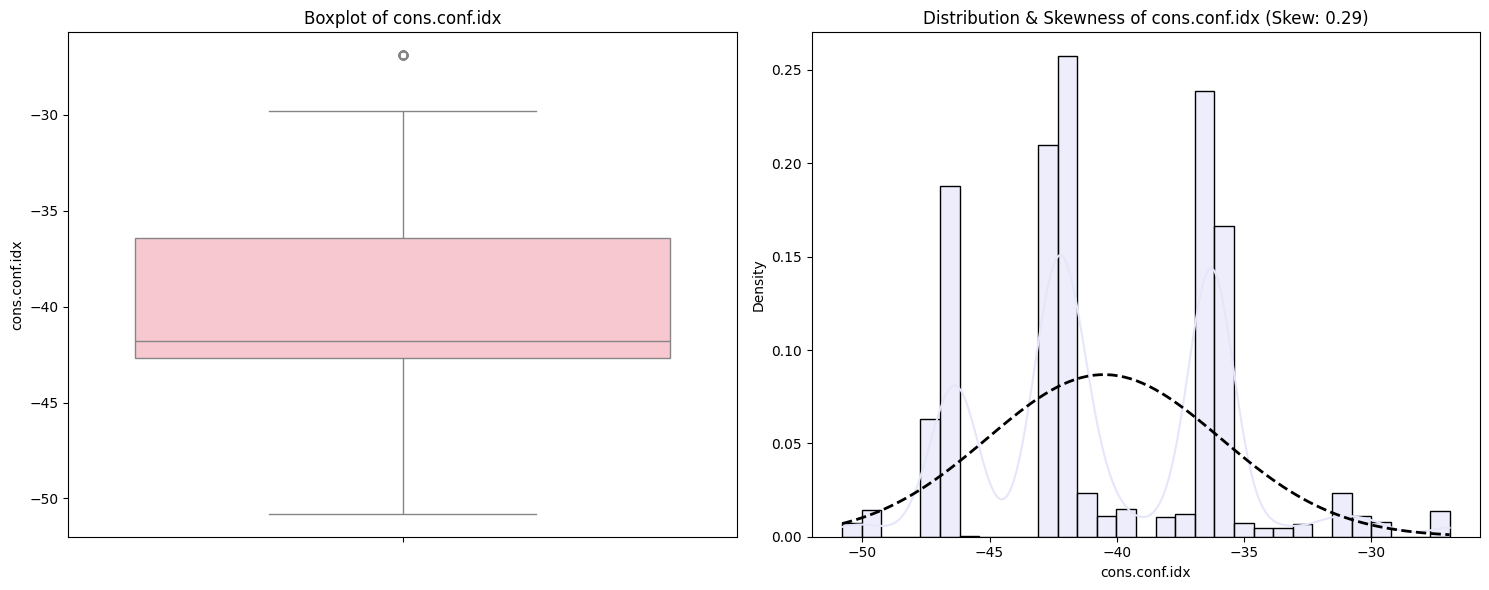

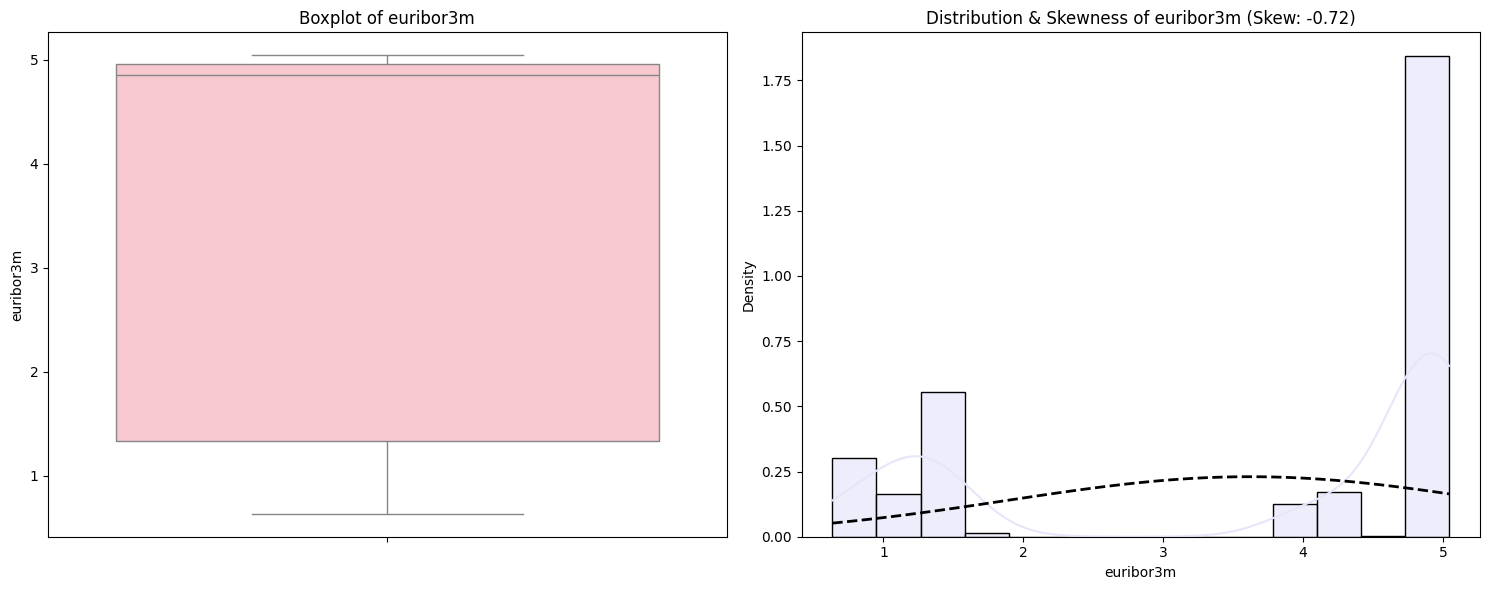

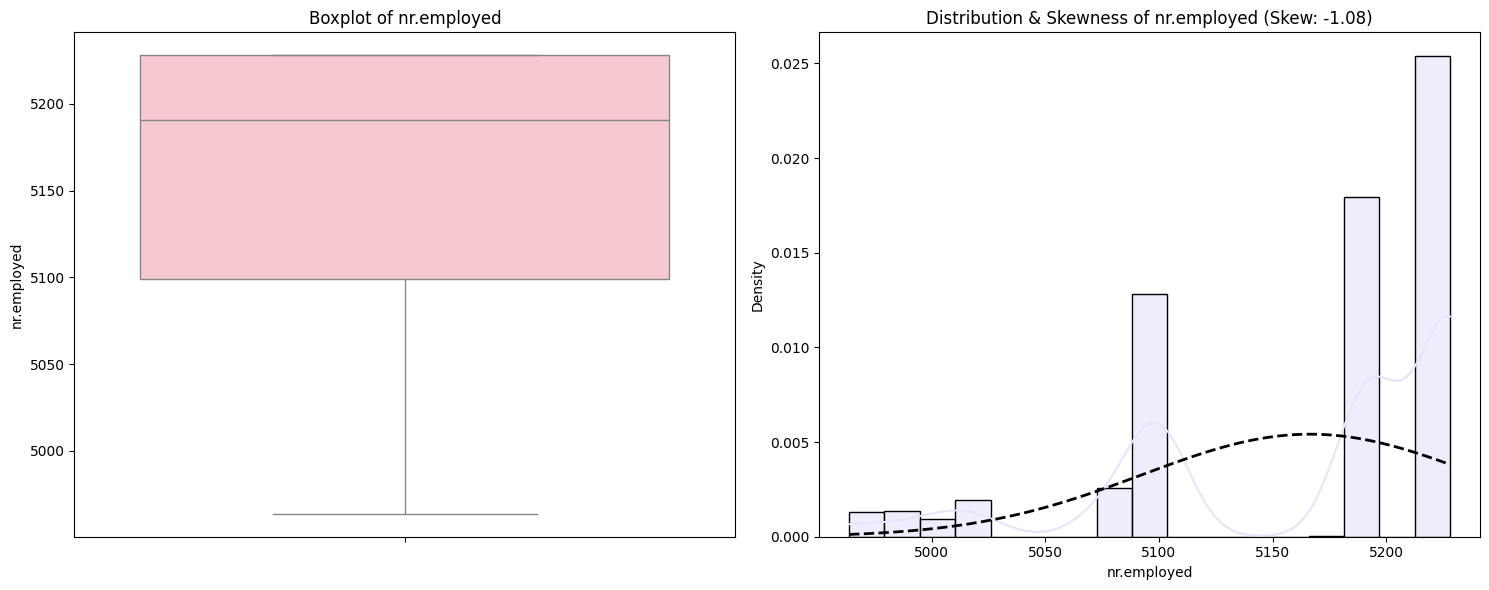

In [9]:
from scipy.stats import norm

# 9. Visualize distribution of numerical features
for var in numerical_cols:
    plt.figure(figsize=(15, 6))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=data[var], color='pink')
    plt.title(f'Boxplot of {var}')
    plt.ylabel(var)

    # Histogram + KDE + Normal distribution overlay
    plt.subplot(1, 2, 2)
    sns.histplot(data[var], kde=True, stat="density", color='lavender', alpha=0.7)
    
    x_vals = np.linspace(data[var].min(), data[var].max(), 100)
    y_vals = norm.pdf(x_vals, loc=data[var].mean(), scale=data[var].std())
    plt.plot(x_vals, y_vals, color='black', linestyle='--', linewidth=2)

    plt.title(f'Distribution & Skewness of {var} (Skew: {data[var].skew():.2f})')
    plt.xlabel(var)

    plt.tight_layout()
    plt.show()

In [10]:
# 11. Fill missing values in categorical columns using the most frequent value
from sklearn.impute import SimpleImputer
# Safely apply most frequent imputation for each categorical column
most_frequent_imputer = SimpleImputer(strategy='most_frequent')

for col in categorical_cols:
    data[col] = most_frequent_imputer.fit_transform(data[[col]]).ravel()  # <- ravel flattens 2D to 1D


In [11]:
# 12. Ordinal encode the 'education' feature
edu_order = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6
}

# Check for unexpected values before mapping
unexpected_vals = set(data['education'].unique()) - set(edu_order.keys())
if unexpected_vals:
    print("Warning: The following 'education' values are not in the mapping dictionary:", unexpected_vals)

# Map known values to ordinal scale
data['education'] = data['education'].map(edu_order)


In [12]:
# 12. Define features and target variable
X = data.drop(columns='y')  # or use the actual target column name if it's different
y = data['y']

In [13]:
from sklearn.preprocessing import OneHotEncoder

# 13. One-Hot Encode categorical variables

# Identify categorical columns
categorical_cols = X.select_dtypes(include='object').columns

# Initialize OneHotEncoder (drop first to avoid multicollinearity)
encoder = OneHotEncoder(drop='first', sparse_output=False)  # if you're using sklearn >= 1.2
# For sklearn < 1.2 use: sparse=False

# Fit and transform categorical data
encoded = encoder.fit_transform(X[categorical_cols])

# Convert encoded data to DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X.index
)

# Keep only numerical features
numeric_df = X.drop(columns=categorical_cols)

# Concatenate numerical and encoded categorical features
X_processed = pd.concat([numeric_df, encoded_df], axis=1)

# Preview final processed feature set
X_processed.head()


,age,education,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,30,3,487,2,999,0,-1.8,92.893,-46.2,1.313,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,39,4,346,4,999,0,1.1,93.994,-36.4,4.855,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,4,227,1,999,0,1.4,94.465,-41.8,4.962,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,38,3,17,3,999,0,1.4,94.465,-41.8,4.959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,47,6,58,1,999,0,-0.1,93.200,-42.0,4.191,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import pickle

# One-hot encoding for categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=data.index)
numeric_df = data.drop(columns=categorical_cols)
data_sklearn_encoded = pd.concat([numeric_df, encoded_df], axis=1)

# Separate features and target variable
X = data_sklearn_encoded.drop('y', axis=1)
y = data_sklearn_encoded['y']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scalers and pipelines
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
pipelines = {}

# Scaler + Model combinations (VarianceThreshold is now inside pipeline)
for scaler in scalers:
    scaler_name = scaler.__class__.__name__

    pipelines[f'knn_{scaler_name}'] = Pipeline([
        ('scaler', scaler),
        ('variance_filter', VarianceThreshold(threshold=0.0)),
        ('feature_selection', SelectKBest(score_func=f_classif, k=15)),
        ('knn', KNeighborsClassifier())
    ])

    pipelines[f'log_reg_{scaler_name}'] = Pipeline([
        ('scaler', scaler),
        ('variance_filter', VarianceThreshold(threshold=0.0)),
        ('feature_selection', SelectKBest(score_func=f_classif, k=15)),
        ('log_reg', LogisticRegression(max_iter=1000))
    ])

    pipelines[f'svm_{scaler_name}'] = Pipeline([
        ('scaler', scaler),
        ('variance_filter', VarianceThreshold(threshold=0.0)),
        ('feature_selection', SelectKBest(score_func=f_classif, k=15)),
        ('svm', SVC())
    ])

# Models that do not require scaling
pipelines['decision_tree'] = Pipeline([
    ('variance_filter', VarianceThreshold(threshold=0.0)),
    ('feature_selection', SelectKBest(score_func=f_classif, k=15)),
    ('decision_tree', DecisionTreeClassifier())
])

pipelines['random_forest'] = Pipeline([
    ('variance_filter', VarianceThreshold(threshold=0.0)),
    ('feature_selection', SelectKBest(score_func=f_classif, k=15)),
    ('random_forest', RandomForestClassifier())
])

# Grid Search parameters
grid_params = {
    f'knn_{scaler.__class__.__name__}': {
        'knn__n_neighbors': [3, 5, 7, 9],
        'knn__weights': ['uniform', 'distance']
    } for scaler in scalers
}
grid_params.update({
    f'log_reg_{scaler.__class__.__name__}': {
        'log_reg__C': [0.1, 1, 10],
        'log_reg__penalty': ['l2'],
        'log_reg__solver': ['lbfgs']
    } for scaler in scalers
})
grid_params.update({
    f'svm_{scaler.__class__.__name__}': {
        'svm__C': [0.1, 1, 10],
        'svm__kernel': ['linear', 'rbf']
    } for scaler in scalers
})
grid_params['decision_tree'] = {
    'decision_tree__max_depth': [None, 5, 10, 20],
    'decision_tree__min_samples_split': [2, 5, 10]
}
grid_params['random_forest'] = {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [None, 5, 10],
    'random_forest__min_samples_split': [2, 5, 10]
}

# Training and evaluation
best_models = {}
best_scores = {}
best_f1_scores = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipeline in pipelines.items():
    print(f"\nRunning GridSearchCV for {name}...")
    grid_search = GridSearchCV(pipeline, grid_params[name], cv=kf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_

    y_pred = grid_search.best_estimator_.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    best_f1_scores[name] = f1

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validated accuracy for {name}: {grid_search.best_score_:.4f}")
    print(f"Test set F1 score for {name}: {f1:.4f}")

# Top 3 models
sorted_best_models = sorted(best_f1_scores.items(), key=lambda x: x[1], reverse=True)
top_3_models = sorted_best_models[:3]

# Save and report top 3 models
for rank, (model_name, f1_score_value) in enumerate(top_3_models, 1):
    model = best_models[model_name]
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    feature_selector = model.named_steps['feature_selection']
    selected_features_indices = feature_selector.get_support(indices=True)
    selected_features_names = [X.columns[i] for i in selected_features_indices]

    model_data = {
        'model': model,
        'selected_features': selected_features_names
    }

    file_name = f'best_model_{rank}_{model_name}.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump(model_data, f)

    print(f"\nModel {rank}: {model_name}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Selected Features: {selected_features_names}")
    print("Confusion Matrix:")
    print(conf_matrix)



Running GridSearchCV for knn_StandardScaler...
Best parameters for knn_StandardScaler: {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Best cross-validated accuracy for knn_StandardScaler: 0.9050
Test set F1 score for knn_StandardScaler: 0.8827

Running GridSearchCV for log_reg_StandardScaler...
Best parameters for log_reg_StandardScaler: {'log_reg__C': 10, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}
Best cross-validated accuracy for log_reg_StandardScaler: 0.9175
Test set F1 score for log_reg_StandardScaler: 0.8997

Running GridSearchCV for svm_StandardScaler...
Best parameters for svm_StandardScaler: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validated accuracy for svm_StandardScaler: 0.9126
Test set F1 score for svm_StandardScaler: 0.8825

Running GridSearchCV for knn_MinMaxScaler...
Best parameters for knn_MinMaxScaler: {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Best cross-validated accuracy for knn_MinMaxScaler: 0.9023
Test set F1 score for knn_MinMaxSca

In [18]:
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
